In [ ]:
from multihead_TL_fctT import *
from multihead_model_bcT import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})


In [ ]:
model_name = 'Multi_4heads50000'

L=2
T=5
x_span = (0, L) #spatial domain
t_span = (0, T) #time domain

Nx= 100 #number of spatial points
Nt = 100 #number of time points
x, t, grid = generate_interior_tensor(IG=(Nx, Nt), x_span=(0, L), t_span=(0, T), require_grad=False)
# print(x.shape, type(t), type(grid))

# create a grid of points in space and time
X_grid = np.linspace(0, L, Nx)
t_eval = np.linspace(0, T, Nt)
mesh_x, mesh_t = np.meshgrid(X_grid, t_eval)
model, training_log, NN_solution = load_pretrain_model(model_name=model_name,mesh_grid = grid,Nx=Nx,Nt=Nt)
# print("NN solution shape:", NN_solution.shape)
# print(log)



In [3]:
print(training_log)


{'model': Multihead_model(
  (act): Tanh()
  (linear1): Linear(in_features=2, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=400, bias=True)
  (final_layers): ModuleList(
    (0-3): 4 x Linear(in_features=400, out_features=1, bias=False)
  )
), 'exp_name': 'Multi_4heads50000', 'k': 4, 'equation_info': {'c': 1}, 'domain_info': {'L': 2, 'T': 5, 't_eval': array([0.        , 0.05050505, 0.1010101 , 0.15151515, 0.2020202 ,
       0.25252525, 0.3030303 , 0.35353535, 0.4040404 , 0.45454545,
       0.50505051, 0.55555556, 0.60606061, 0.65656566, 0.70707071,
       0.75757576, 0.80808081, 0.85858586, 0.90909091, 0.95959596,
       1.01010101, 1.06060606, 1.11111111, 1.16161616, 1.21212121,
       1.26262626, 1.31313131, 1.36363636, 1.41414141, 1.46464646,
       1.51515152, 1.56565657, 1.61616162, 1.66666667, 1.71717172,
       1.76767677, 1.81818182, 1.86868687, 1.91919192, 1.96969697,
       2.02

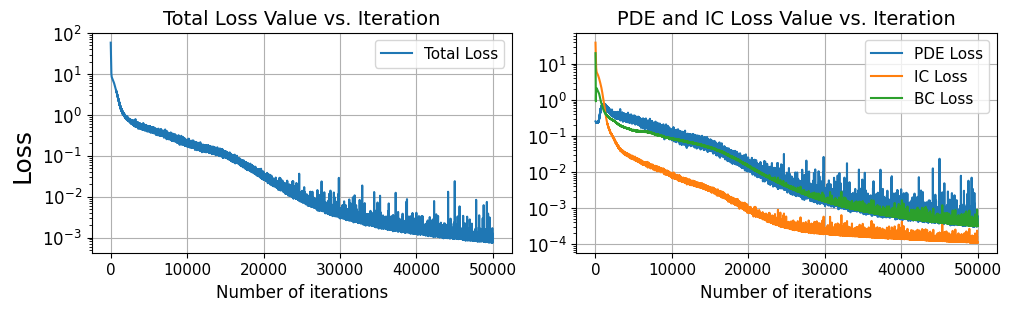

In [4]:
plot_loss(loss_trace = training_log['loss_trace']['total'],pde_trace= training_log['loss_trace']['pde'], bc_trace= training_log['loss_trace']['bc'], ic_trace= training_log['loss_trace']['ic'], data_trace= None, path= None)


In [5]:
print(training_log['Nic'])

100


In [6]:
H_dict = compute_H_dict(model = model,IG = (Nx,Nt),Nic = Nx,Nbc = Nt, bias = False,x_span= x_span,t_span= t_span,log = training_log)

Differentiating H w.r.t. x now...
Finished computing H2x.
Differentiating H w.r.t. t now...
Finished computing H2t
Differentiating H_ic w.r.t. t now...
Finished computing Ht_bc


### Transfer for linear

In [7]:
_, _, _ =compute_M(H_dict= H_dict,w_pde=1,w_ic=10,w_bc=10)

lstsqM


In [8]:
def ic_example(input):
    return  ic_stepexp05(input) + echelon_square(1, 1.7, 0.7,20)(input)

def ic_curve(input):
    x = input[:, 0].unsqueeze(1)
    return 1 + 2*x*(2-x)

def ic_linear(input):
    x = input[:, 0].unsqueeze(1)
    return 1-0.5*x

icD = ic_linear#ic_sin#ic_curve1##ic_linear#initial_condition2#initial_condition1#initial_condition05#constant_function(0)#ic_stepexp05
icN = constant_function(1)
_, H_dict = compute_R_ic(H_dict,ic_functionD=icD, ic_functionN=icN, w_ic=10,log=training_log)#ic_function=ic_linear,


bcs = [constant_function(1), constant_function(0)]  # Define boundary conditions for the left and right boundaries
_,_,_,H_dict = compute_R_bcs(H_dict,boundary_functions=bcs ,w_bc=10, log=training_log)#boundary_values=training_log['equation_info']['boundary_values'][0]





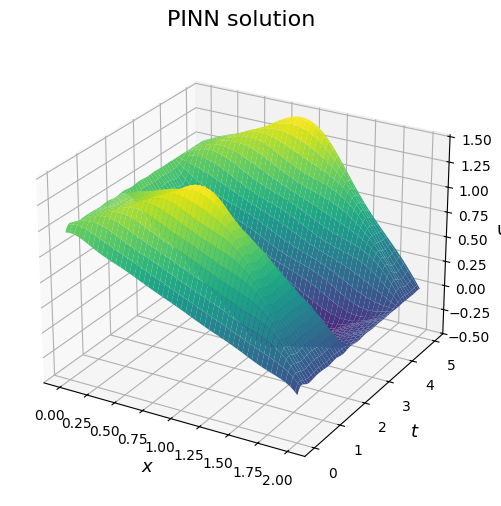

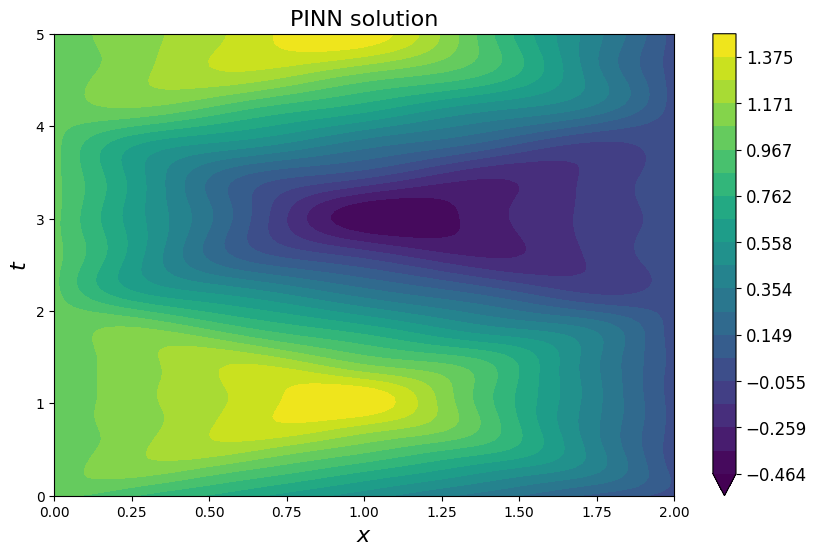

In [9]:
input = torch.cat((x.unsqueeze(1), t.unsqueeze(1)), dim=1)  # Combine x and t into a single input tensor
W, computational_time = compute_TL_with_F(forcing_function=constant_function(0), w_pde= 1,H_dict= H_dict, input = input)

TL_solution = compute_solution(H_dict['H'], W, H_dict['N']).reshape(Nx, Nt)



# Plot the solution
plot_solution1(TL_solution, mesh_x= mesh_x, mesh_t = mesh_t)
plot_solution1(TL_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

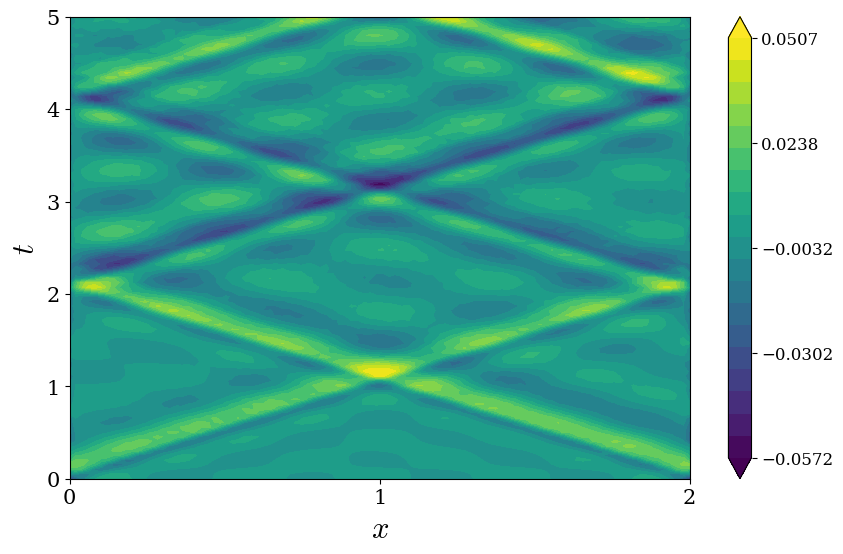

0.010230080601953616


In [ ]:
#####error

error = TL_solution - np.load('sol_linear_homogeneous_line.npy')
plot_solution1(error, mesh_x= mesh_x, mesh_t = mesh_t,surface=False)
print(np.linalg.norm(error, ord=2)/np.linalg.norm(TL_solution, ord=2))

### Solve the non-linear

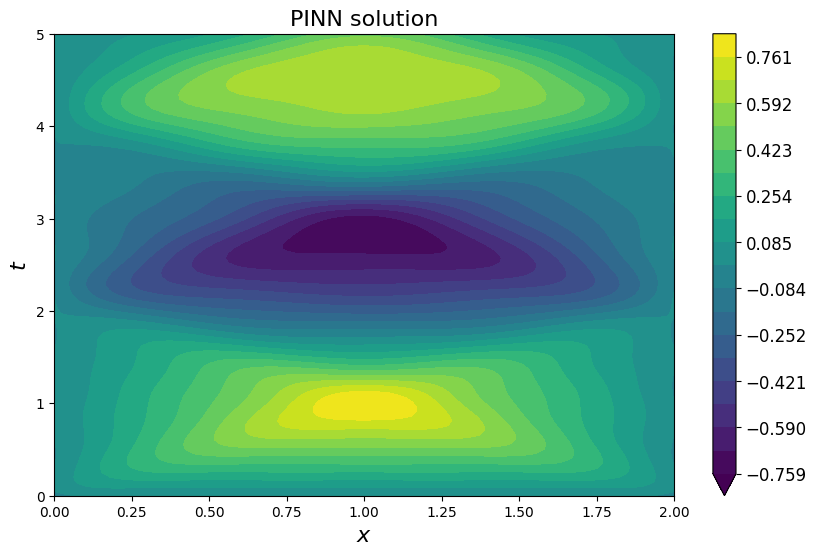

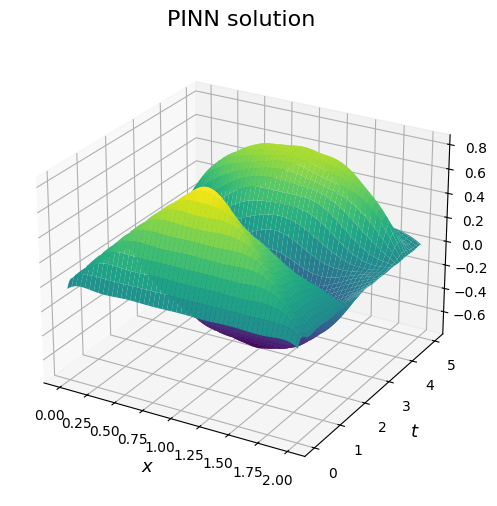

In [ ]:
epsilon = 0.75
p = 12 ###order of the expansion


Polynomial = [[1,1],[-1/6,3]]

bcs=[constant_function(0),constant_function(0)]  # Define boundary conditions for the left and right boundaries
icD = constant_function(0)#ic_stepexp05#constant_function(0)
icN = constant_function(1)
forcing=constant_function(0)

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_functionD=icD,ic_functionN=icN)

NN_TL_pertubation_solution = NN_TL_pertubation_solution.reshape(Nx, Nt)


plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=True)

### Influence of p

In [ ]:
def plot_solution2(solution, mesh_x, mesh_t, surface=True, path=None, title=None, rotation=(25, -60)):
    """
    args:
        solution (np.ndarray): shape (Nx, Nt) or (Nt, Nx)
        mesh_x, mesh_t (np.ndarray): meshgrids of size (Nx, Nt)
        surface (bool): True for 3D surface plot, False for contourf
        path (str): path to save the figure
        title (str): title of the plot
        rotation (tuple): (elev, azim) for 3D view
    """
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d' if surface else None)
    solution = solution.swapaxes(0, 1)  # shape (Nx, Nt)
    
    # Determine vmin/vmax from data
    vmin, vmax = solution.min(), solution.max()
    
    # Force symmetric or zero-centered range if needed
    vmin = min(vmin, 0)
    vmax = max(vmax, 0)
    
    # Generate evenly spaced ticks that always include 0
    num_ticks = 5
    ticks = np.linspace(vmin, vmax, num_ticks)

    if surface:
        surf = ax.plot_surface(mesh_x, mesh_t, solution, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.view_init(rotation[0], rotation[1])
        ax.set_xlabel("$x$", fontsize=22)
        ax.set_ylabel("$t$", fontsize=22)
        ax.set_zlabel("u", fontsize=2)
        
        # Colorbar with fixed ticks
        cbar = fig.colorbar(surf, ax=ax, shrink=0.7, ticks=ticks)
        cbar.set_label("u", fontsize=13)
        cbar.ax.tick_params(labelsize=22)
    
    else:
        levels = np.linspace(vmin, vmax, 20)
        Cs = ax.contourf(mesh_x, mesh_t, solution, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax, extend='both')
        cbar = fig.colorbar(Cs, ax=ax, ticks=ticks)
        cbar.ax.tick_params(labelsize=12)
        ax.set_xlabel("$x$", fontsize=22)
        ax.set_ylabel("$t$", fontsize=22)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(labelsize=15)


    if path is not None:
        fig.savefig(path, bbox_inches='tight')
    else:
        plt.show()


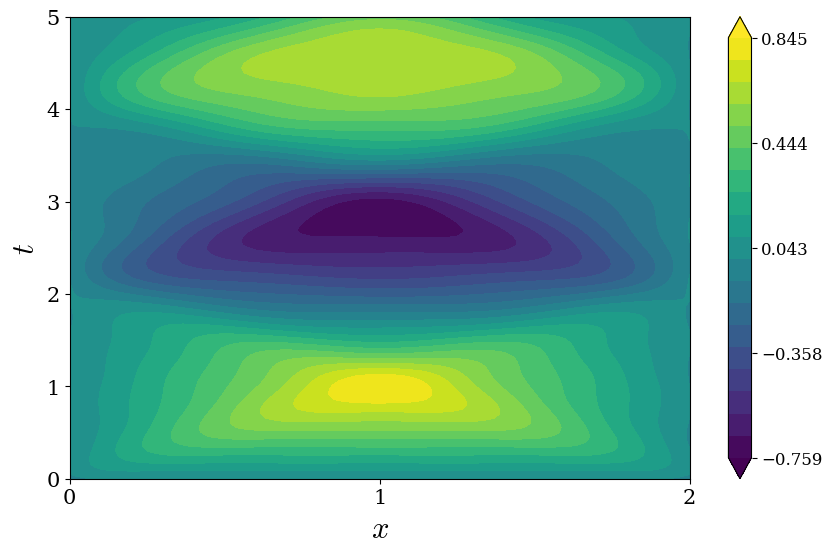

In [132]:
plot_solution2(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

In [12]:
solution_nl = np.load('sol_non_linear_polynomial.npy')

In [135]:
solution_nl.shape

(100, 100)

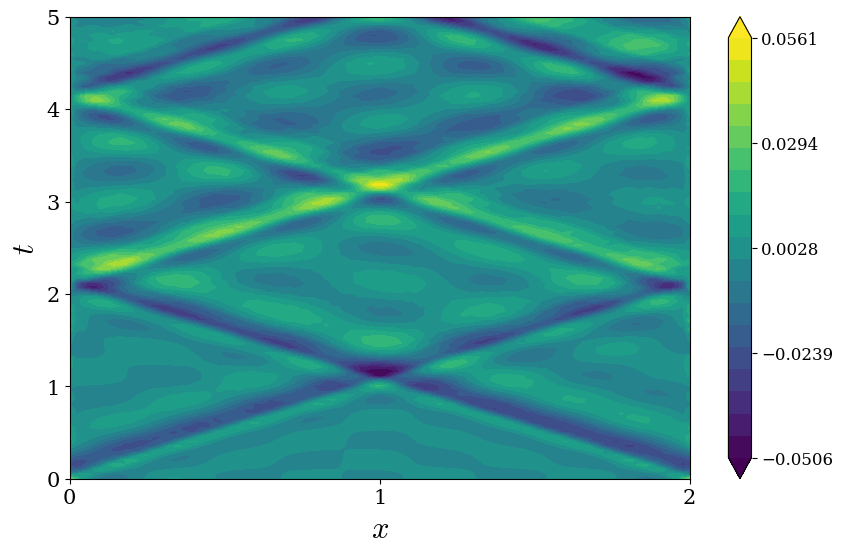

In [137]:
plot_solution2(solution_nl - NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)

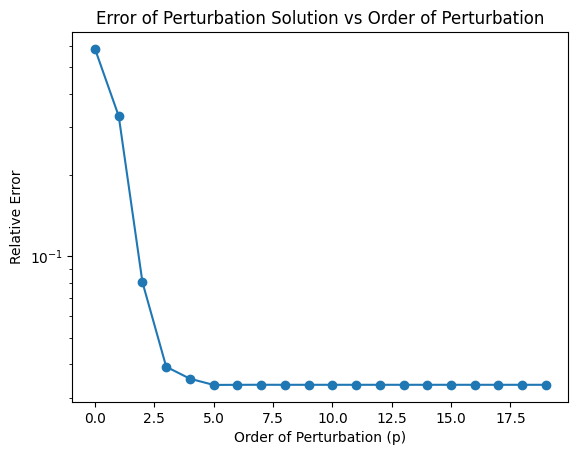

In [13]:
p_list = [i for i in range(20)]  # List of orders of expansion to test
pertubation_error_for_p_complete(p_list=p_list, forcing=forcing, H_dict=H_dict, input=input, training_log=training_log, solution=solution_nl, epsilon=epsilon,Polynomial=Polynomial,boundary_functions=bcs,ic_functionD=icD,ic_functionN=icN,title='Error of pertubation solution for different orders of expansion')


### Pertubation with functions

In [14]:
import math


def taylor_sin(n):
    """
    Génère le polynôme de Taylor de sin(x) tronqué à l'ordre n.
    
    Args:
        n (int): L'ordre de troncature du développement de Taylor.
        
    Returns:
        list: Une liste de listes de la forme [[a_k, k]], où a_k est le coefficient et k la puissance.
              Les coefficients nuls ne sont pas inclus.
    """
    taylor = []
    for k in range(n + 1):
        if k % 2 == 1:  # seuls les termes impairs sont non nuls
            a_k = (-1)**((k - 1) // 2) / math.factorial(k)
            taylor.append([a_k, k])
    return taylor

def taylor_cos(n):
    """
    Génère le polynôme de Taylor de sin(x) tronqué à l'ordre n.
    
    Args:
        n (int): L'ordre de troncature du développement de Taylor.
        
    Returns:
        list: Une liste de listes de la forme [[a_k, k]], où a_k est le coefficient et k la puissance.
              Les coefficients nuls ne sont pas inclus.
    """
    taylor = []
    for k in range(n + 1):
        if k % 2 == 0:  # seuls les termes impairs sont non nuls
            a_k = (-1)**((k - 1) // 2)*(3**k) / math.factorial(k)
            taylor.append([a_k, k])
    return taylor

def taylor_arctan(n):
    taylor = []
    for k in range(n + 1):
        if k % 2 == 1:  # seuls les termes impairs sont non nuls
            a_k = (-1)**((k - 1) // 2) / k
            taylor.append([a_k, k])

    return taylor

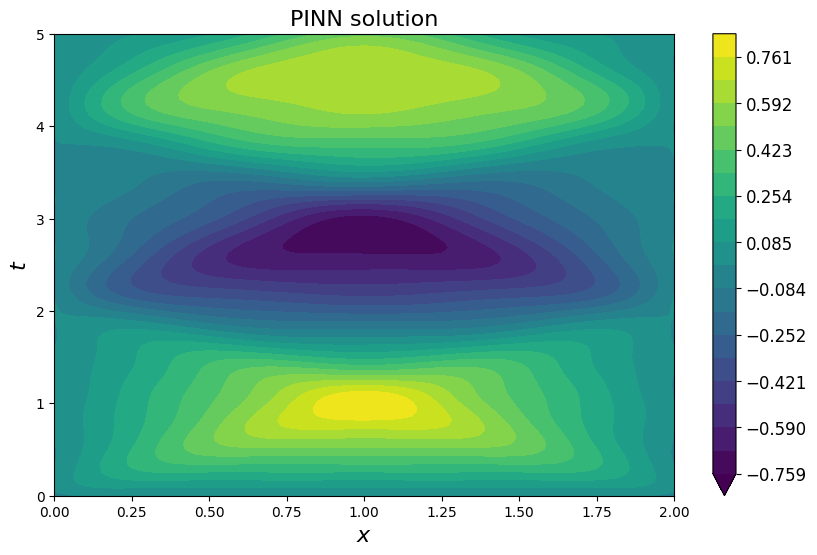

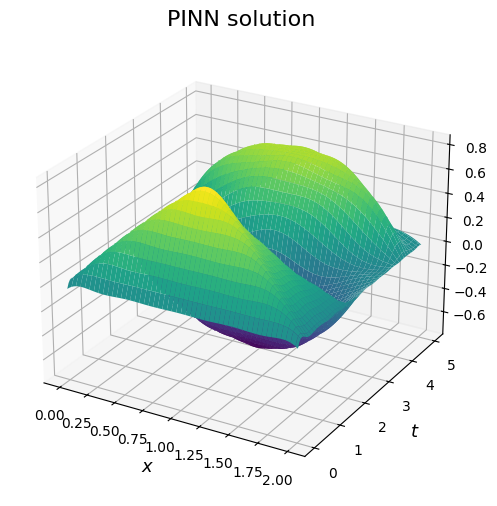

In [15]:
epsilon = 0.75
p = 10  ###order of the expansion


Polynomial = taylor_sin(8)#[[-1,2],[1,3]]

bcs=[constant_function(0),constant_function(0)]  # Define boundary conditions for the left and right boundaries
icD = constant_function(0)#ic_stepexp05#constant_function(0)
icN = constant_function(1)
forcing=constant_function(0)

NN_TL_pertubation_solution, _ = compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_functionD=icD,ic_functionN=icN)

NN_TL_pertubation_solution = NN_TL_pertubation_solution.reshape(Nx, Nt)


plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=False)
plot_solution1(NN_TL_pertubation_solution, mesh_x= mesh_x, mesh_t = mesh_t, surface=True)

### error for the truncated 

In [16]:
numerical_solution = np.load('sol_non_linear_function.npy')

0.03351393335571628


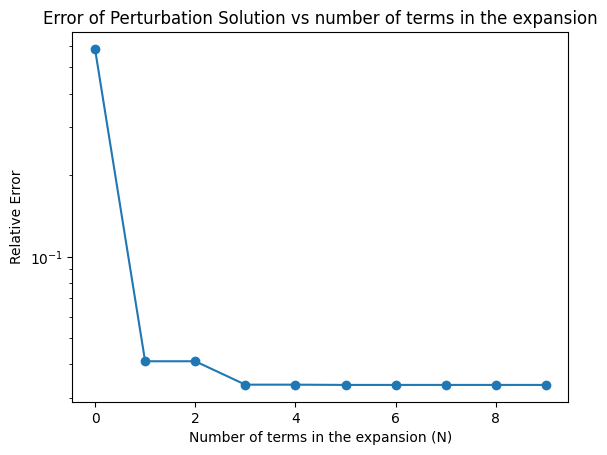

In [17]:
epsilon = 0.75
p = 6  ###order of the expansion


Polynomials = [taylor_sin(i) for i in range(10)]#[[-1,2],[1,3]]

bcs=[constant_function(0),constant_function(0)]  # Define boundary conditions for the left and right boundaries
icD = constant_function(0)#ic_stepexp05#constant_function(0)
icN = constant_function(1)
forcing=constant_function(0) 

pertubation_error_for_truncated_function_complete(p, forcing=forcing, H_dict=H_dict, input=input, training_log=training_log, solution=numerical_solution, epsilon=epsilon,Polynomials=Polynomials,boundary_functions=bcs,ic_functionD=icD,ic_functionN=icN)
